# Network motifs
In this notebook, we will be exploring how to work with network motifs. You will first need the following two modules. Networx is one of the main network science libraries for python. It has many functions built in for network analysis https://networkx.org/. We will also need the packages below. You may already have them installed, if so, you can skip the first cell, and just load them in the second cell.

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install random
!{sys.executable} -m pip install time

In [ ]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import random as rd
import time

We will investigate motif counts in one of two data sets, so first let's load the data that you are interested in. Here, I included two sources of data: one of the hamsterer social network, and one router network. Choose whichever you like, and comment the other one out. 

###  <font color='red'>When using Jupyter notebook on donwloaded GitHub folder, run the cell below</font>

In [ ]:
G = nx.read_adjlist("router_network.txt")     #read adjacency list into a graph object
G = nx.read_adjlist("hamsterer.txt")    #read graphml file into a graph object


print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
avgdeg = sum(dict(G.degree).values()) / len(G.nodes)
print('Average degree', avgdeg)

### <font color='red'>When using Google collab run the two cells below instead:</font>

The rest of the notebook is the same regardless of which method you used. Again, to change to another data set, comment the one that you do not use out.

In [ ]:
!git clone https://github.com/clarastegehuis/Complex_Networks_applications_school/

In [ ]:
G = nx.read_adjlist('/content/Complex_Networks_applications_school/hamsterer.txt')     #read adjacency list into a graph object
G = nx.read_adjlist('/content/Complex_Networks_applications_school/router_network.txt')     #read adjacency list into a graph object

print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
avgdeg = sum(dict(G.degree).values()) / len(G.nodes)
print('Average degree', avgdeg)

# Part 1: Relating Orbits

In this part, we are trying to compute the number of times a node x appears in a specific 4-node motif role, by using 3-vertex subgraph counts, $G_1$ (path) and $G_2$ (triangle).

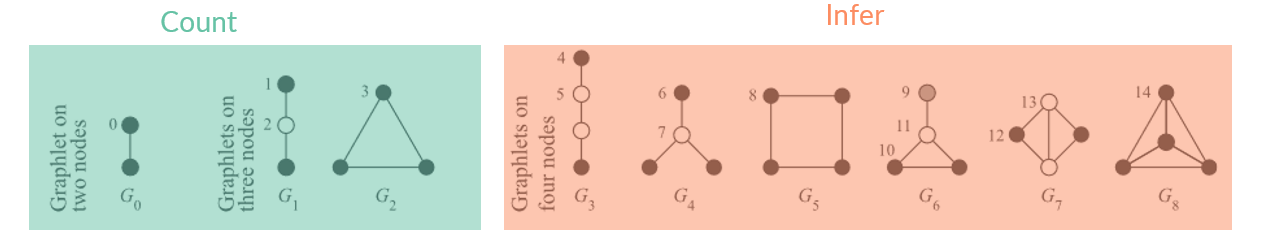

## Exercise 1
Relate the orbits $o_9$ and $o_6$ to the path counts $p(x,y)$, in the form
$$a \times o_6 + b\times  o_9 = \sum_{y,z: x,y,z = G_1}p(x,y)-1 .$$
In the code, you can adjust $a$ and $b$ and check whether it indeed counts the orbits correctly. The codes will also show the time it takes to compute the right-hand side of the equation (depending on only 3-vertex subgraphs), and the one of the left-hand side (computing 4-node subgraph counts).

Hint: Try to see what the possible 4-vertex subgraphs are when you add a node $w$, that is not connected to $x$ to the path $x,y,z$, and what the orbit of $x$ would be in that subgraph, see the image:

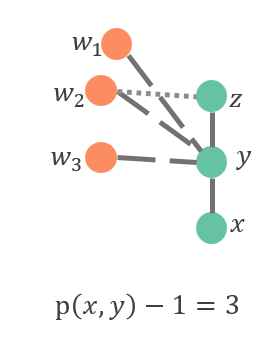

In [ ]:
time_start = time.time()
triangles = nx.triangles(G)

def pxycount(G,x,y): #The function that computes the number of length 3 paths containing node x as end node and node y as a middle node
    neighbors_y = list(G.neighbors(y))
    if x in neighbors_y:
        pxy_count = len(neighbors_y)-1
    else:
        pxy_count = 0
    return pxy_count

pxydict = {} #The dictionary that will contain the pxycount(x,y) for all edges (x,y)
for edge in G.edges():
    pxydict[(edge[0],edge[1])] = pxycount(G,edge[0],edge[1])
    pxydict[(edge[1],edge[0])] = pxycount(G,edge[1],edge[0])

def pxysum(G,x): #The function that computes the sum of pxycount(x,y)-1 over all neighbors y for a given node x
    neighbors = list(G.neighbors(x))
    pxysum = 0
    for neighbor in neighbors:
        pxysum += (pxydict[(x,neighbor)]-1)*(G.degree(neighbor)-1)
    return pxysum

#The vector that will contain the right hand side of the equation for each node
for node in G.nodes:
    G.nodes[node]["pxysum"]=pxysum(G,node)
print("time it takes to compute the right-hand side of the equation:", time.time()-time_start)


In [ ]:
time_start = time.time()

def o9(G,x): #The function that computes the times node x appears as orbit 9
    neighbors = list(G.neighbors(x))
    o9_count = 0
    for neighbor in neighbors:
        potential_degree = (G.degree(neighbor)-1)*(G.degree(neighbor)-2)/2
        o9_count += potential_degree-(triangles[neighbor]-len(nx.common_neighbors(G,x,neighbor)))
    return o9_count

def o6(G,x): #The function that computes the times node x appears as orbit 6
    neighbors = list(G.neighbors(x))
    o6_count = 0
    for neighbor in neighbors:
        o6_count += triangles[neighbor]-len(nx.common_neighbors(G,x,neighbor))
    return o6_count


# Here you can relate the orbit counts to the path counts:
o6_factor =           # a in the equation above
o9_factor =           # b in the equation above

#The vector that will contain the left hand side of the equation for each node
for node in G.nodes:
        G.nodes[node]["orbit6_9"]=(int(o6_factor*o6(G,node)+o9_factor*o9(G,node)))
print("time it takes to count 4-vertex orbits o6 and o9:",time.time()-time_start, '\n')


print('check whether the weighted orbit counts are the same as the sum over the p(x,y)s:')
# Generate a check to see if the factors are correct:

for (i,node) in enumerate(G.nodes):
        print(f"Node {node}:\t a*o_6+b*o_9 = {G.nodes[node]["orbit6_9"]},\t sum p(x,y)-1 = {G.nodes[node]['pxysum']}")


## Bonus exercise (Part 1)

Link the orbit counts $o_{13}$ and $o_{14}$ to the sum of common neighbors of $x$ and $z$ $c(x,z)$, and common neighbors of $x$ and $y$ $c(x,y)$.

$$a*o_{13}+b*o_{14} = \sum_{y,z: x,y,z=\triangle}c(x,y)-1+c(x,z)-1. $$
Here, you can try to extend a triangle between $x,y,z$ into a four-node subgraph by adding a node $w$ that is connected to both $x$ and $y$, and see what possible 4-node subgraphs can appear. You can use the following picture

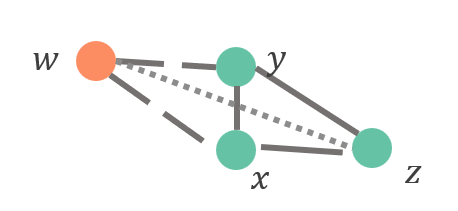


In [ ]:
time_start = time.time()

# Define the orbit counts and the c(x,y) counts that count triangles.
def c(G,x,y):
    return len(nx.common_neighbors(G,x,y))

for edge in G.edges():
    G[edge[0]][edge[1]]['cxy'] = c(G,edge[0],edge[1])


# the right-hand-side of the abve equation
def sum_cxy(G,x):
    neighbors = list(G.neighbors(x))
    sum_cxy = 0
    for (i,neighbor1) in enumerate(neighbors):
        for neighbor2 in neighbors[i+1:]:
            if G.has_edge(neighbor1,neighbor2):
                sum_cxy += G[x][neighbor2]['cxy']-1+G[x][neighbor1]['cxy']-1
    return sum_cxy

rhsvec_ex_2 = [] #The vector that will contain the right hand side of the equation for each node
for node in G.nodes:
    rhsvec_ex_2.append(sum_cxy(G,node))
print("time it takes to compute the right-hand side of the equation:", time.time()-time_start)

# orbit counts o_13 and o_14
def o13_o14(G,x):
    o13 = 0
    o14 = 0
    neighbors = list(G.neighbors(x))
    for (i,neighbor1) in enumerate(neighbors):
        for neighbor2 in neighbors[i+1:]:
            templist = nx.common_neighbors(G,neighbor1,neighbor2)
            for z in templist:
                if z in neighbors:
                    if G.has_edge(neighbor1,neighbor2):
                        o14 += 1/3
                    else:
                        o13 += 1
    return o13, o14

In [ ]:
time_start = time.time()

# here you can relate the orbit counts to the triangle counts by filling in the correct factors
o13factor =       # fill in the right value of a in the equation above
o14factor =       # fill in the right value of b in the equation above

lhsvec_ex_2 = [] #The vector that will contain the left hand side of the equation for each node
for node in G.nodes:
    lhsvec_ex_2.append(int(o13factor*o13_o14(G,node)[0]+o14factor*o13_o14(G,node)[1]))

print("time it takes to count 4-vertex orbits o13 and o14:",time.time()-time_start, '\n')

print('check whether the weighted orbit counts are the same as the sum over the c(x,y)s:')
# Generate a check to see if the factors are correct:
for (i,node) in enumerate(G.nodes):
    print(f"Node {node}:\t a*o_13+b*o_14 = {lhsvec_ex_2[i]},\t sum c(x,y)-1+c(x,z)-1 = {rhsvec_ex_2[i]}")

# Part 2
## Random sampling
Sometimes it is not possible to count the exact number of subgraphs in a large networks due to large computation times. One of the solutions to this problem is to use sampling instead. Many methods to sample subgraphs exist, but here we focus on the simplest one of them, creating a subsample of the network where every node is included with probability $q$. Then, it computes subgraphs (in this case cliques) in the reduced graph. To be able to compare our sampling algorithm to the ground truth, we first count the number of all cliques in the data:

In [ ]:
clique_list = nx.enumerate_all_cliques(G)   

def cliquenumber(cliques,k):                #A function that takes a list with all cliques in the graph, and then reports the number of k-cliques
    k_clique_num = 0
    for i in cliques:
        if len(i)==k:
            k_clique_num += 1
    return k_clique_num

k = 3
clique_count_G = cliquenumber(clique_list,k)
print(clique_count_G)

# Exercise 2
Fill in the blanks in the code below to obtain an estimate for the number of cliques in the larger graph from this sampled clique count. 

In [ ]:
def sampled_cliques(Graph,sample_prob,size): # This function takes in a graph Graph, and returns an estimated clique count for cliques of size 'size'
    nsampled = int((1-sample_prob)*len(Graph.nodes()))
    sample = rd.sample(list(Graph.nodes), nsampled)    
    H=Graph.copy()
    H.remove_nodes_from(sample)            #remove every vertex in Graph independently with probability 1-p

    clique_list_sampled = nx.enumerate_all_cliques(H)  
    sampled_clique_count = cliquenumber(clique_list_sampled,size)        # the clique count in the subsampled graph

    estimated_clique_count =           # figure out how to compute the estimated clique count from sampled_clique_count
    return estimated_clique_count

To check your code, the cell below creates 100 subgraph count estimates with sampling probability $q$, and plots them together with the data count (dashed line). 

In [ ]:
def plot_triads(countvec,datacount):    #This function plots a histogram of countvec, with a horizontal line at datacount
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.hist(countvec, alpha = 0.65)
    plt.style.use("bmh")

    ax.set_yticks([])
    ax.grid(False)
    ax.tick_params(left = False, bottom = False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)
    plt.xlabel("clique counts",size = 17)
    plt.ylabel("frequency",size = 17)
    plt.axvline(datacount, color = 'k', linestyle='dashed', linewidth=2)

    # Show plot
    plt.show()

In [ ]:
start_time = time.time()
q = 0.7                     # the probability that a node is included in the sample

sampledvec = []
for i in range(100):
    sampledvec.append(sampled_cliques(G,q,k))
plot_triads(sampledvec,clique_count_G)
print("time it takes to estimate triangle count:", time.time()-start_time)

# Part 3: Neighborhood sampling
Below, we would like to create an unbiased neighborhood sampling algorithm to approximate the density of triangles. First, we define a function that computes the triangle density of a graph:

In [ ]:
triad_count = sum(nx.triangles(G).values()) / 3 #In networkx, every triangle is counted 3 times, due to reordering of the vertices
print(triad_count, " triangles")

def triad_density(Graph):
    sumpairs = 0
    degrees = [d for n, d in G.degree()]
    for d in degrees:
        sumpairs += d*(d-1)/2
    sumpairs -= 2* triad_count
    return triad_count/sumpairs

In [ ]:
print(triad_density(G))

Now, we create a neighborhood sampling algorithm to approximate the triangle density. Add the probabilities that the algorithm samples the paths and subgraphs below to complete it, and compare it to the empirical triad density.

In [ ]:
start_time = time.time()
G_edge_count = len(G.edges())                               # the number of edges of G
S_triad=0                                                   #sum of weights for triangles
S_tot=0                                                     #sum of weights for all 3-nodes subgraphs
N_samples = 500                                             # The number of random samples
for k in range(N_samples):                                        
    random_sampled_edge = rd.sample(list(G.edges),1)        #sample random edge (u,v)
    u = random_sampled_edge[0][0]
    v = random_sampled_edge[0][1]
    sample_list = []
    for i in G[u]:
        if i!=v:
            sample_list.append(i)                           #add all neighbors of u to the list
    for j in G[v]:
        if j!=u:
            sample_list.append(j)                           #add all neighbors of v to the list
    if sample_list == []:
        continue
    w = rd.sample(sample_list,1)[0]                         #sample random vertex w  from the set of neighbors of u and v
    
    if G.has_edge(u,w) and G.has_edge(v,w):                 # if u,v,w is a triangle
        P=   #What is the probability that triangle (u,v,w) is sampled? You may use that the number of neighbors of a node u is len(G[u])
        S_triad+=1/P
    else:
        if G.has_edge(u,w):
            P=        #What is the probability that path (w,u,v) is sampled?
        if G.has_edge(v,w):
            P=        #What is the probability that path (u,v,w) is sampled?
            
    S_tot+=1/P
print(S_triad/S_tot)
print("time it takes to estimate triangle density:", time.time()-start_time)

# Part 3, motif counts with respect to different random graph models

## Exercise 1 
Count the number of triangles in the data sets

In [ ]:
triad_count = sum(nx.triangles(G).values()) / 3 #In networkx, every triangle is counted 3 times, due to reordering of the vertices
print(triad_count, " triangles")

Now let's say that we take an Erdos Renyi model as a null model to test for whether a statistically significant number of triangles is present. First figure out what the correct values of $n$ and $p$ are to compare the ER-model with your data set.

In [ ]:
n =               # fill in the correct value of n
p =     # fill in the correct value of p
print('p = ', p, ' n = ', n)

With these values for $n$ and $p$, we can generate let's say 100 ER models that should serve as null models for the data sets, and count triangles in those null models. 

In [ ]:
test_triad_counts = []  # vector with triangle counts in the ER model
for i in range(100):
    G_test = nx.erdos_renyi_graph(n,p)
    test_triad_counts.append(sum(nx.triangles(G_test).values()) / 3)

Now plot a histogram of the generated triangle counts from the ER model together with the triangle count in the network data

In [ ]:
def plot_triads(countvec,datacount):    #This function plots a histogram of countvec, with a horizontal line at datacount
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.hist(countvec, alpha = 0.65)
    plt.style.use("bmh")

    ax.set_yticks([])
    ax.grid(False)
    ax.tick_params(left = False, bottom = False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)
    plt.xlabel("triangle counts",size = 17)
    plt.ylabel("frequency",size = 17)
    plt.axvline(datacount, color = 'k', linestyle='dashed', linewidth=2)

    # Show plot
    plt.show()

In [ ]:
plot_triads(test_triad_counts,triad_count)

Now compute the Z-score of the triangle counts:

In [ ]:
def Zscore(countvec,datacount):       #compute the Z score of datacount, when the null model produces as samples countvec
    meancount = np.average(countvec)
    std_count = np.std(countvec)     # standard deviation of triangle counts in null model
    return (datacount-meancount)/std_count

In [ ]:
print('Zscore is ',Zscore(test_triad_counts,triad_count))

### Configuration model
Now let's try the same thing in the configuration model. The input for the configuration model is a degree sequence, and it creates a random graph on those degrees. So first generate the correct input for the configuration model to be able to compare it to the data, and then compare triangle counts. 

In [ ]:
degree_sequence =  # Pick the correct degree sequence

test_triad_config = []
for i in range(100):
    G_config = nx.configuration_model(degree_sequence)
    G_config= nx.Graph(G_config)
    test_triad_config.append(sum(nx.triangles(G_config).values()) / 3)
plot_triads(test_triad_config,triad_count)
print('Zscore is ',Zscore(test_triad_config,triad_count))

### Geometric random graph 
Now let's try yet another null model, the geometric random graph. Here, the input parameters are the radius $r$ and the number of vertices $n$. This model assumes that all $n$ vertices are uniformly placed in a $[0,1]^2$ box, and that every vertex connects with vertices within radius $r$. First, find the values of $r$ and $n$ for which you would be able to compare them to your data set, and then compare triangle counts. You may need that np.pi is the number $\pi$.

In [ ]:
radius =   # compute the radius which you think makes the Geometrc random graph a good null model

G_geom = nx.random_geometric_graph(n, radius)

test_triad_geom = []
for i in range(100):
    G_geom = nx.random_geometric_graph(n, radius)
    test_triad_geom.append(sum(nx.triangles(G_geom).values()) / 3)
plot_triads(test_triad_geom,triad_count)
print('Zscore is ', Zscore(test_triad_geom,triad_count))

## Questions
What are the differences between the different random graph odels?

Are triangles always significant according to the Z-score?

Are there differences when selecting different data sets?

# Part 2
##  Other motifs
We now investigate some other motif types. For simplicity, we will stick with cliques. First, lets generate a list of all cliques in the network, and a function that then counts all cliques of size $k$.

In [ ]:
def cliquenumber(cliques,k):                #A function that takes a list with all cliques in the graph, and then reports the number of k-cliques
    k_clique_num = 0
    for i in cliques:
        if len(i)==k:
            k_clique_num += 1
    return k_clique_num

Pick a value of $k$ that you are interested in (probably very large cliques do not appear so often, so you may want to choose it not so much bigger than 3). Then perform the clique count in the data.

In [ ]:
k = 3
clique_count_G = cliquenumber(clique_list,k)
print(clique_count_G)

You can now try the different null models for larger clique sizes and compare. The code now has the ER graph as a null mode, but you can try the other two null models as well:

In [ ]:
test_kclique_counts = []
for i in range(100):
    G_test = nx.erdos_renyi_graph(n,p)
    G_test_cliques = nx.enumerate_all_cliques(G_test) 
    test_kclique_counts.append(cliquenumber(G_test_cliques,k))
plot_triads(test_kclique_counts,clique_count_G)

### Questions
Do other $k$-cliques appear significantly often compared to the random graph models?

### Questions
How close is the sampled subgraph count to the actual one?

How small can $q$ be to still obtain accurate estimates?

How does this depend on the clique size $k$?